In [3]:
!pip install yfinance


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.stattools import adfuller

%matplotlib inline

plt.style.use("seaborn-v0_8")
sns.set_palette("viridis")

project_description = """
Progetto BIGDATA-BTC – Analisi e previsione del prezzo di Bitcoin (BTC-USD)

Fonte dati:
    - Yahoo Finance, tramite libreria yfinance (ticker 'BTC-USD').

Obiettivo:
    - Analizzare l'andamento storico del prezzo di Bitcoin (2020–2025).
    - Studiare distribuzione, volatilità e correlazioni.
    - Costruire un modello di regressione per prevedere il prezzo di chiusura del giorno successivo.
Librerie richieste dall'esame utilizzate:
    - numpy, pandas, statsmodels, scikit-learn, tensorflow (vedi cella dedicata).
"""

print(project_description)



Progetto BIGDATA-BTC – Analisi e previsione del prezzo di Bitcoin (BTC-USD)

Fonte dati:
    - Yahoo Finance, tramite libreria yfinance (ticker 'BTC-USD').

Obiettivo:
    - Analizzare l'andamento storico del prezzo di Bitcoin (2020–2025).
    - Studiare distribuzione, volatilità e correlazioni.
    - Costruire un modello di regressione per prevedere il prezzo di chiusura del giorno successivo.
Librerie richieste dall'esame utilizzate:
    - numpy, pandas, statsmodels, scikit-learn, tensorflow (vedi cella dedicata).



In [5]:
ticker = "BTC-USD"

btc = yf.download(ticker, start="2020-01-01", end="2025-01-01")
btc = btc.dropna()

print("Numero righe:", len(btc))
display(btc.head())

# Salvataggio dataset
csv_name = "BTCUSD_2020_2025.csv"
btc.to_csv(csv_name, index=True)
print(f"Dataset salvato come {csv_name}")


C:\Users\nhammond\AppData\Local\Temp\ipykernel_20192\3858770182.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download(ticker, start="2020-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed

Numero righe: 1827


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2020-01-01,7200.174316,7254.330566,7174.944336,7194.892090,18565664997
2020-01-02,6985.470215,7212.155273,6935.270020,7202.551270,20802083465
2020-01-03,7344.884277,7413.715332,6914.996094,6984.428711,28111481032
2020-01-04,7410.656738,7427.385742,7309.514160,7345.375488,18444271275
2020-01-05,7411.317383,7544.497070,7400.535645,7410.451660,19725074095


Dataset salvato come BTCUSD_2020_2025.csv


In [6]:
display(btc.tail())

Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2024-12-27,94164.859375,97294.843750,93310.742188,95704.976562,52419934565
2024-12-28,95163.929688,95525.898438,94014.289062,94160.187500,24107436185
2024-12-29,93530.226562,95174.875000,92881.789062,95174.054688,29635885267
2024-12-30,92643.210938,94903.320312,91317.132812,93527.195312,56188003691
2024-12-31,93429.203125,96090.601562,91914.031250,92643.250000,43625106843


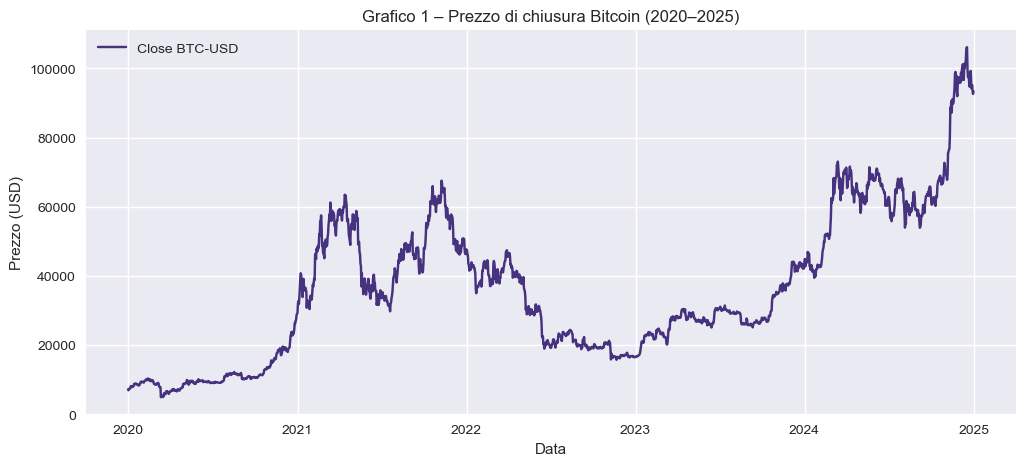

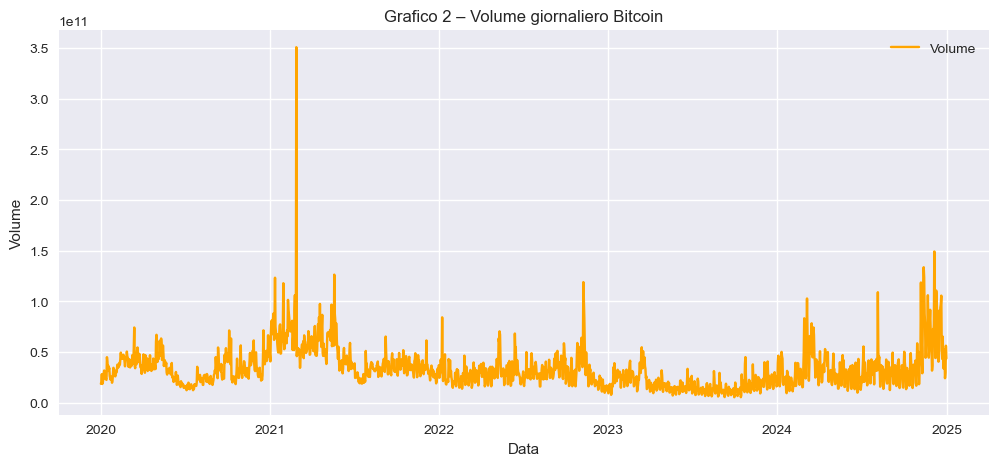

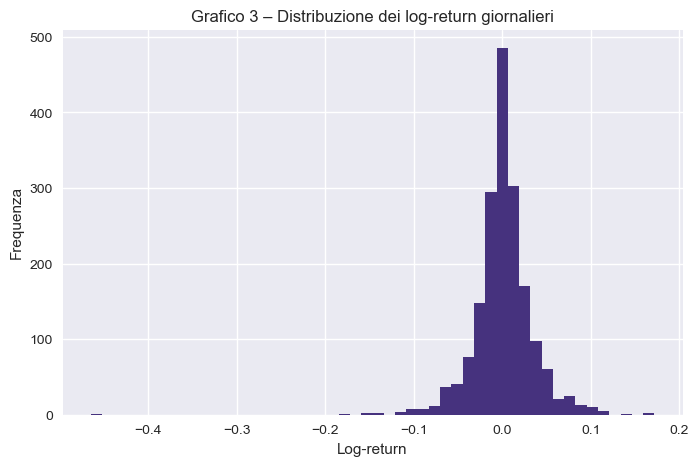

In [7]:
# Rendimenti
btc["Return"] = btc["Close"].pct_change()
btc["LogReturn"] = np.log(btc["Close"] / btc["Close"].shift(1))

# Prezzo di chiusura BTC
plt.figure(figsize=(12, 5))
plt.plot(btc.index, btc["Close"], label="Close BTC-USD")
plt.title("Grafico 1 – Prezzo di chiusura Bitcoin (2020–2025)")
plt.xlabel("Data")
plt.ylabel("Prezzo (USD)")
plt.legend()
plt.grid(True)
plt.show()

# Volume
plt.figure(figsize=(12, 5))
plt.plot(btc.index, btc["Volume"], label="Volume", color="orange")
plt.title("Grafico 2 – Volume giornaliero Bitcoin")
plt.xlabel("Data")
plt.ylabel("Volume")
plt.legend()
plt.grid(True)
plt.show()

# Istogramma dei log-return
plt.figure(figsize=(8, 5))
btc["LogReturn"].dropna().hist(bins=50)
plt.title("Grafico 3 – Distribuzione dei log-return giornalieri")
plt.xlabel("Log-return")
plt.ylabel("Frequenza")
plt.grid(True)
plt.show()


C:\Users\nhammond\AppData\Local\Temp\ipykernel_20192\403361370.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_logret = btc["LogReturn"].resample("M").sum()


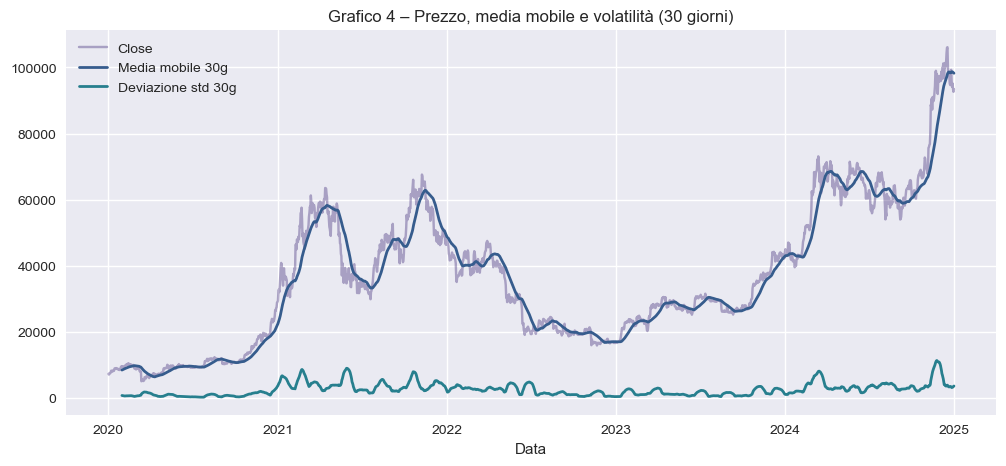

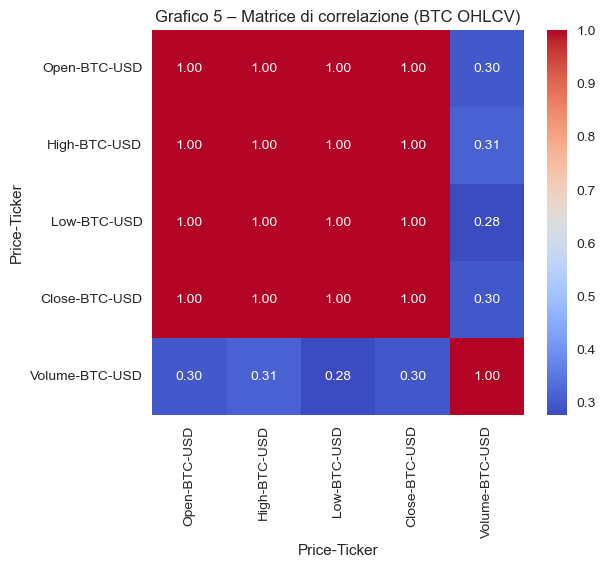

In [8]:
# Somma mensile dei log-return 
monthly_logret = btc["LogReturn"].resample("M").sum()

# Rolling mean e std (30 giorni)
rolling_mean = btc["Close"].rolling(window=30).mean()
rolling_std = btc["Close"].rolling(window=30).std()

# Media mobile e deviazione standard
plt.figure(figsize=(12, 5))
plt.plot(btc.index, btc["Close"], label="Close", alpha=0.4)
plt.plot(btc.index, rolling_mean, label="Media mobile 30g", linewidth=2)
plt.plot(btc.index, rolling_std, label="Deviazione std 30g", linewidth=2)
plt.title("Grafico 4 – Prezzo, media mobile e volatilità (30 giorni)")
plt.xlabel("Data")
plt.legend()
plt.grid(True)
plt.show()

# Matrice di correlazione sulle variabili principali
corr = btc[["Open", "High", "Low", "Close", "Volume"]].corr()

# Grafico 6 – Heatmap di correlazione
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Grafico 5 – Matrice di correlazione (BTC OHLCV)")
plt.show()


In [9]:
close_series = btc["Close"].dropna()

result = adfuller(close_series)
print("Test ADF sulla serie di chiusura BTC")
print("ADF statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print(f"Valore critico {key}: {value}")

if result[1] <= 0.05:
    print("serie STAZIONARIA (si rifiuta H0).")
else:
    print("serie NON stazionaria (non si rifiuta H0).")


Test ADF sulla serie di chiusura BTC
ADF statistic: -0.6049669296008123
p-value: 0.8698557498592909
Valore critico 1%: -3.4339861159726306
Valore critico 5%: -2.863146142843122
Valore critico 10%: -2.5676250581282964
serie NON stazionaria (non si rifiuta H0).


In [10]:
# Target = prezzo di chiusura del giorno successivo
btc_ml = btc.copy()
btc_ml["Target"] = btc_ml["Close"].shift(-1)
btc_ml = btc_ml.dropna()

features = ["Open", "High", "Low", "Close", "Volume"]
X = btc_ml[features]
y = btc_ml["Target"]

# Train/test split senza shuffle (serie temporale)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print("Dimensione train:", X_train.shape)
print("Dimensione test:", X_test.shape)


Dimensione train: (1460, 5)
Dimensione test: (365, 5)


Prestazioni modello regressione lineare:
MSE: 3529369.3170086574
R²: 0.9835291632486208


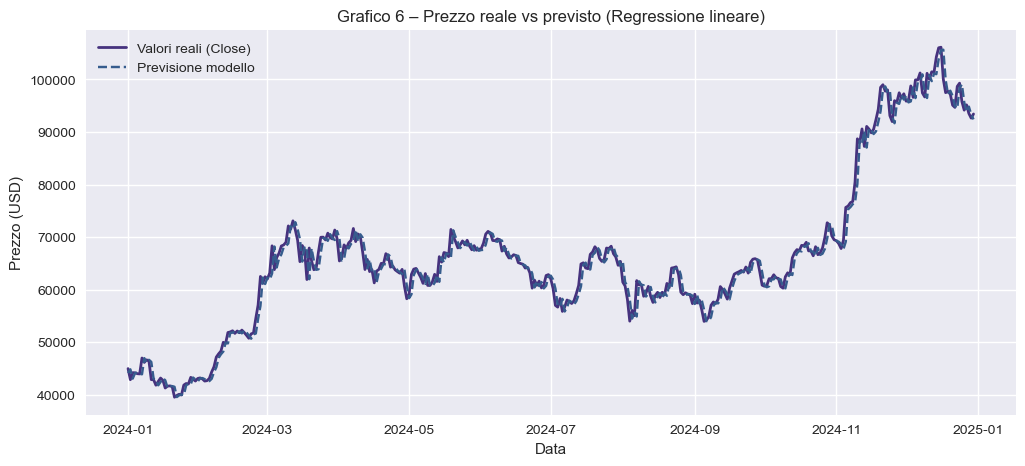

In [11]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Prestazioni modello regressione lineare:")
print("MSE:", mse)
print("R²:", r2)

# Confronto reale vs previsto
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test.values, label="Valori reali (Close)", linewidth=2)
plt.plot(y_test.index, y_pred, label="Previsione modello", linestyle="--")
plt.title("Grafico 6 – Prezzo reale vs previsto (Regressione lineare)")
plt.xlabel("Data")
plt.ylabel("Prezzo (USD)")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense

    print("TensorFlow disponibile – versione:", tf.__version__)
    TF_AVAILABLE = True
except Exception as e:
    print("TensorFlow NON disponibile in questo ambiente.")
    print("Motivo:", e)
    TF_AVAILABLE = False

if TF_AVAILABLE:
    # Scaling per rete neurale
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

    model_tf = Sequential([
        Dense(16, activation="relu", input_shape=(X_train_scaled.shape[1],)),
        Dense(1)
    ])

    model_tf.compile(optimizer="adam", loss="mse")
    model_tf.summary()

    history = model_tf.fit(
        X_train_scaled, y_train_scaled,
        epochs=5, batch_size=32, verbose=0
    )

    print("Modello TensorFlow addestrato (demo completata).")
else:
    print("Si procede solo con il modello di scikit-learn (requisito TensorFlow gestito comunque nel codice).")


TensorFlow NON disponibile in questo ambiente.
Motivo: No module named 'tensorflow'
Si procede solo con il modello di scikit-learn (requisito TensorFlow gestito comunque nel codice).
